In [1]:
import torch
import json
import os
from importlib.machinery import SourceFileLoader
from matplotlib import pyplot as plt

from pado.light import * 
from pado.optical_element import *
from pado.propagator import *

from utils.utils import *

In [2]:
import skimage

def visualize(tensor, cmap='hsv', vmin=None, vmax=None, figsize=None, axis=True, title=None, psnr=None, ssim=None, l1=None):
    plt.figure(figsize=figsize)
    if (vmin is not None) and (vmax is not None):
        plt.imshow(tensor[0].permute(1,2,0).cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.imshow(tensor[0].permute(1,2,0).cpu().detach().numpy(), cmap=cmap)
    if axis:
        plt.colorbar()
    else:
        plt.axis('off')
    title_string = title if title is not None else '' 
    title_string += f' l1: {l1:.3f}' if l1 is not None else ''
    title_string += f' psnr: {psnr:.3f}' if psnr is not None else ''
    title_string += f' ssim: {ssim:.3f}' if ssim is not None else ''
    plt.title(title_string)
    plt.show()

def grayscale(np_img):
    return (np_img[:,:,0]+np_img[:,:,1]+np_img[:,:,2])/3

def compute_psnr(GT, image):
    psnr = skimage.metrics.peak_signal_noise_ratio(
        GT[0].permute(1, 2, 0).cpu().detach().numpy(), image[0].permute(1, 2, 0).cpu().detach().numpy())
    return psnr

def compute_ssim(GT, image):
    ssim = skimage.metrics.structural_similarity(
        GT[0].mean(axis=0).cpu().detach().numpy(), image[0].mean(axis=0).cpu().detach().numpy())
    return ssim

def compute_psf(wvl, light, args, propagator, offset=(0, 0), normalize=True, resize=True):
    '''simulate depth based psf.
    Args:
        depth: propagation distance
        propagator: propagator defined in pado library. Fresenl, Fraunhofer, Rayleigh-Sommerfeld (RS), ASM, or BL_ASM
        use_lens: If True, DOE is placed in front of the lens.
        offset: (offset_y, offset_x) tuple. metric is meter. coordinate system follows matrix indexing ((0,0) is the top left corner.)
        theta: incident angle (theta_y, theta_x) of the point light source
        pad: If True, pad or unpad the psf size to be same as image size
        full_psf: If True, build full PSF which is impossible during training

    Note that Fresenl propagation with propagation distance focal length light after refractive lens is
    equal to the Fraunhofer propagation with propagation distance focal length.
    '''
    param = args.param
    prop = Propagator(propagator)
    dim = (1,1,param.R, param.C)

    aperture = Aperture(dim, param.DOE_pitch, param.aperture_diamter, param.aperture_shape, wvl, args.device)
    light = aperture.forward(light.clone())

    light_prop = prop.forward(light, param.sensor_dist, offset=offset, linear=True)
    psf = light_prop.get_intensity()

    # resize 
    if resize:
        psf = F.interpolate(psf, scale_factor=light_prop.pitch/(param.camera_pitch* param.image_sample_ratio), 
                            mode=args.resizing_method)
    if normalize:
        psf = psf / torch.sum(psf)

    return psf

from tqdm import tqdm 
from pado.material import Material

def psf_XZ_vis(args, complex_field, depths, incident_z, wvl, normalizer=None):
    bl_asm = Propagator('SBL_ASM')
    aperture = Aperture(complex_field.shape, args.param.DOE_pitch, args.param.DOE_pitch*complex_field.shape[-1], 'circle', wvl, args.device)

    for idx, depth in tqdm(enumerate(depths)):
        light = Light(complex_field.shape, args.param.DOE_pitch, wvl,device=args.device)
        light.set_spherical_light(z=incident_z)
        light.set_field(complex_field*light.get_field())
        aperture.wvl = wvl
        light = aperture.forward(light.clone())
        psf = bl_asm.forward(light.clone(), depth, offset=(0,0), linear=False).get_intensity()
        psf = psf[0, :, psf.shape[-2]//2-30:psf.shape[-2]//2+30, psf.shape[-1]//2-30:psf.shape[-1]//2+30].permute(1,2,0).cpu().detach().numpy()
        psf = psf if normalizer is None else psf/normalizer
        psf_1d = psf.sum(axis=0)
        if idx==0:
            psf_depth = np.zeros((psf.shape[0], len(depths)))
        psf_depth[:, idx] = psf_1d.squeeze()

    if normalizer is None:
        psf_depth = psf_depth/psf_depth.max()

    print(args.param.DOE_pitch, psf.shape[-1])

    plt.figure(figsize=(10, 5))
    plt.imshow(psf_depth, extent=[depths[0]*1e3, depths[-1]*1e3, 
                                  -args.param.DOE_pitch*psf_depth.shape[0]*1e6/2, args.param.DOE_pitch*psf_depth.shape[0]*1e6/2], 
               interpolation='nearest', cmap='hot', aspect='auto')
    plt.xlabel('z (mm)')
    plt.ylabel('x (1um)')
    plt.title(f'wvl: {wvl*1e+9}nm, depth: {incident_z*1e+3}mm, z: {depths[0]*1e3}mm ~ {depths[-1]*1e3}mm')
    plt.tight_layout()
    plt.colorbar()
    plt.show()
    

In [3]:
from scipy.io import savemat, loadmat
from lut import KeyedLUTSampler, KeyedLUTSampler3D_HardGumbel_Complex

ckpt_path = '../Friday_log/doublet2'
args = json.load(open(ckpt_path + '/args.json'))
args = AttributeDict(args)

concat=False

args.device = 'cuda:3' 

param = SourceFileLoader("param", os.path.join(ckpt_path,args.param_file.split('/')[-1])).load_module()
args.param = param
# saved_map_fname = 'minimum_eval_loss.pt'
saved_map_fname = '009.pt'

layer1_indices = torch.load(ckpt_path+'/layer1_indices_'+saved_map_fname, map_location=args.device).detach()
layer2_indices = torch.load(ckpt_path+'/layer2_indices_'+saved_map_fname, map_location=args.device).detach()
shape_indices = torch.load(ckpt_path+'/shape_indices_'+saved_map_fname, map_location=args.device).detach()

cycy = torch.tensor(np.load('./library/cycy.npy'), device=args.device).to(torch.complex64)
cysq = torch.tensor(np.load('./library/cysq.npy'), device=args.device).to(torch.complex64)
sqcy = torch.tensor(np.load('./library/sqcy.npy'), device=args.device).to(torch.complex64)
sqsq = torch.tensor(np.load('./library/sqsq.npy'), device=args.device).to(torch.complex64)
lut_dict = {450:torch.stack([cycy[...,0], cysq[...,0], sqcy[...,0], sqsq[...,0]], dim=0), 
            532:torch.stack([cycy[...,1], cysq[...,1], sqcy[...,1], sqsq[...,1]], dim=0), 
            635:torch.stack([cycy[...,2], cysq[...,2], sqcy[...,2], sqsq[...,2]], dim=0)}
lut_sampler = KeyedLUTSampler3D_HardGumbel_Complex(lut_dict).to(args.device)
lut_sampler.eval()

KeyedLUTSampler3D_HardGumbel_Complex()

# PSF at high resolution

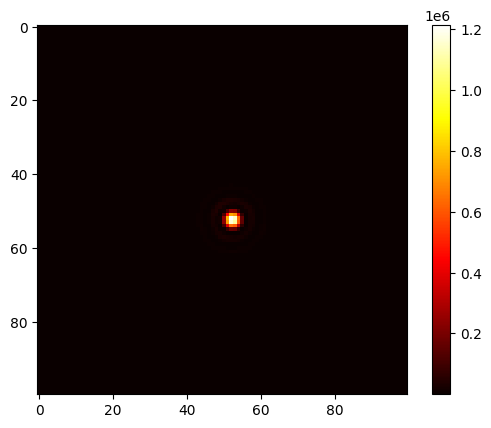

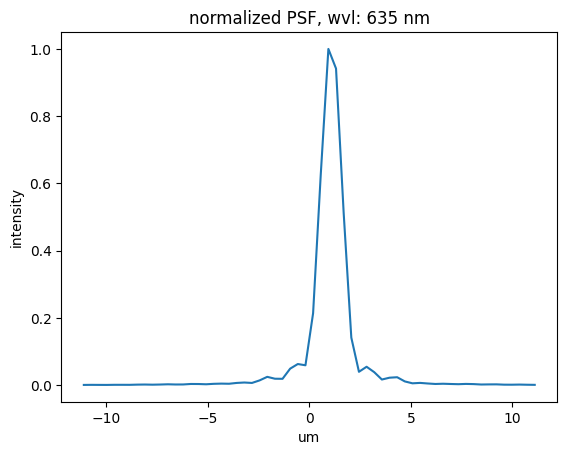

tensor(272222.0312, device='cuda:3') tensor(4338200., device='cuda:3') tensor(222.6286, device='cuda:3')


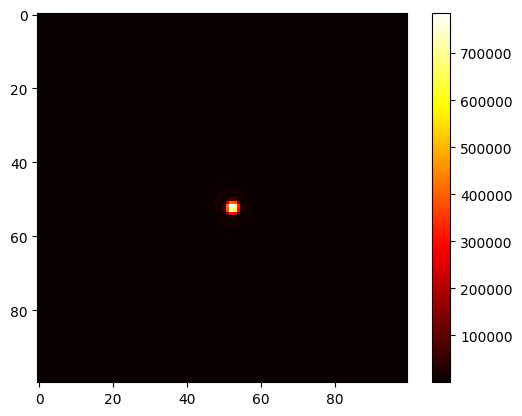

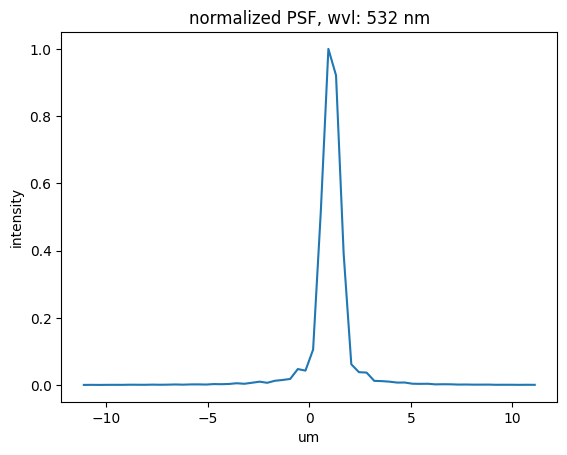

tensor(114766.1875, device='cuda:3') tensor(2410145., device='cuda:3') tensor(307.9106, device='cuda:3')


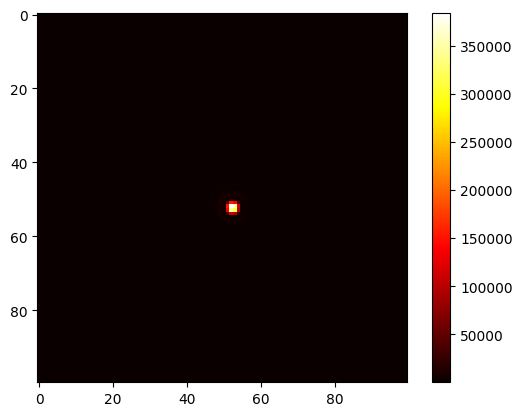

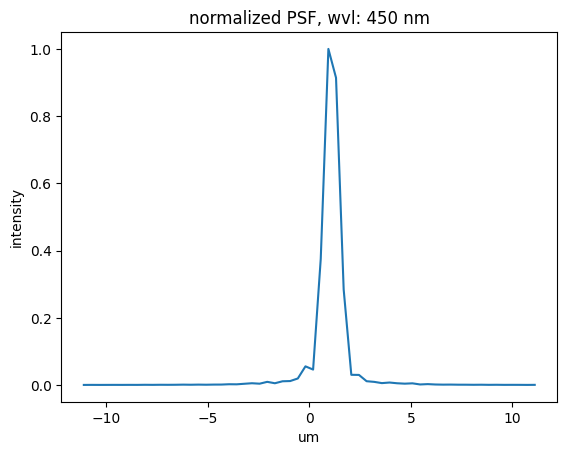

tensor(56912.8516, device='cuda:3') tensor(1024394.6250, device='cuda:3') tensor(430.2135, device='cuda:3')


In [4]:
for wvl in [635e-9, 532e-9, 450e-9]:
    double_layer_complex_grid = torch.concat([2.0*torch.sigmoid(layer2_indices)-1, 
                            2.0*torch.sigmoid(layer1_indices)-1,
                            2.0*torch.sigmoid(shape_indices)-1], dim=1) # 세로 축이 layer2임
    complex_field = lut_sampler(keys=[int(wvl*1e+9)], grid=double_layer_complex_grid)[int(wvl*1e+9)]
    light = pado.Light((1,1,param.R, param.R), pitch=param.DOE_pitch, wvl=wvl, field=complex_field, device=args.device)
    psf = compute_psf(wvl, light, args, 'SBL_ASM', offset=(0, 0), normalize=False, resize=False)

    visualize(psf[...,psf.shape[-2]//2-50:psf.shape[-2]//2+50, psf.shape[-1]//2-50:psf.shape[-1]//2+50], cmap='hot')

    d1 = psf[...,psf.shape[-2]//2-30:psf.shape[-2]//2+30, psf.shape[-1]//2-30:psf.shape[-1]//2+30].sum(axis=-2).squeeze()

    plt.plot(np.linspace(-d1.shape[0]//2, d1.shape[0]//2, d1.shape[0])*param.DOE_pitch*1e6, d1.cpu().detach().numpy()/d1.max().item())
    plt.title('wvl: '+str(int(wvl*1e+9))+' nm')
    plt.xlabel('um')
    plt.ylabel('intensity')
    plt.title('normalized PSF, wvl: '+str(int(wvl*1e+9))+' nm')
    plt.show()
    print(d1[:d1.shape[0]//2].max(), d1.max(), d1.max()/d1[:d1.shape[0]//3].max())

# Z-scan

0it [00:00, ?it/s]/workspace/MultiLayerLUTMetalens/pado/light.py:280: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, device=self.device)[None, None, :, :]
100it [00:11,  8.69it/s]


3.7e-07 1


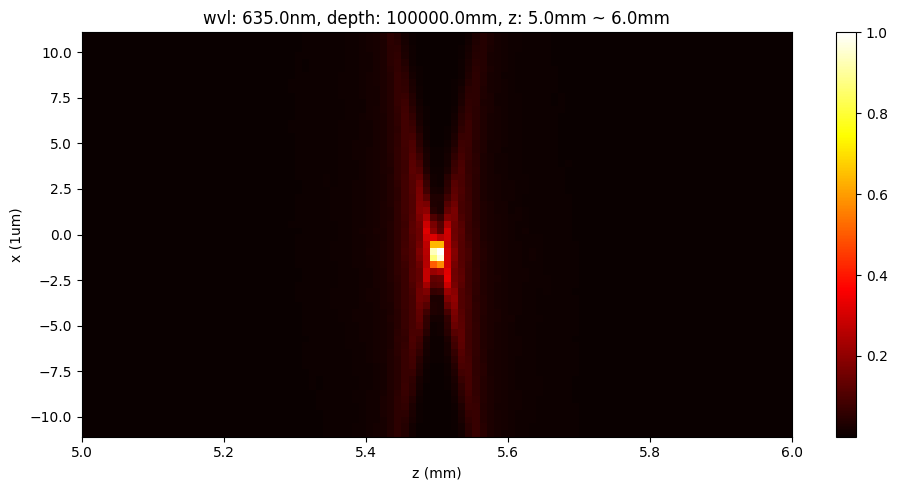

100it [00:11,  8.67it/s]


3.7e-07 1


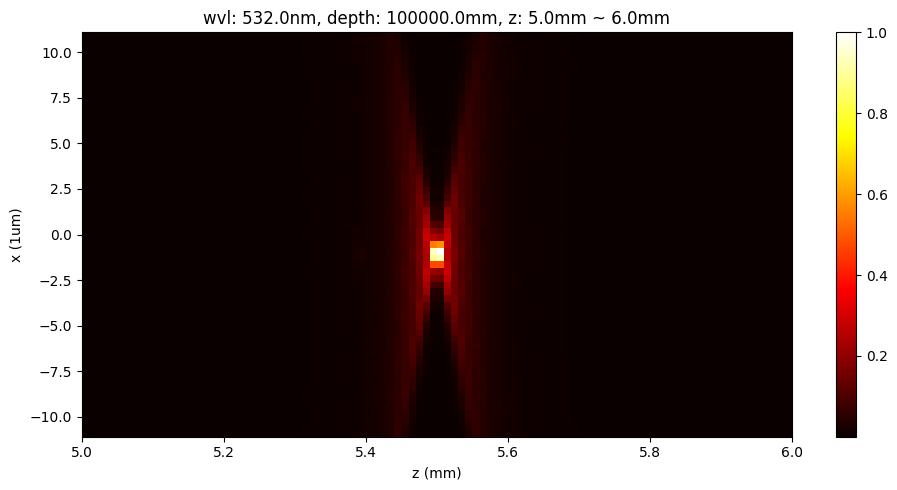

100it [00:11,  8.69it/s]


3.7e-07 1


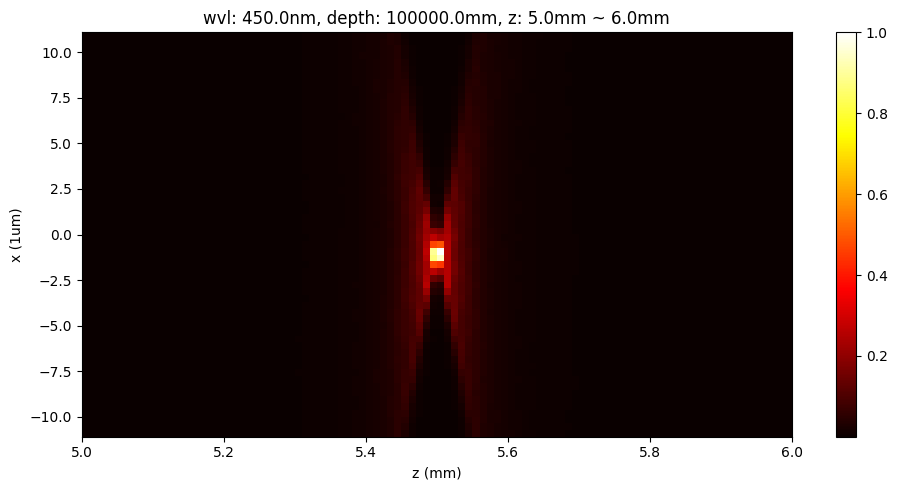

In [5]:
for wvl in [635e-9, 532e-9, 450e-9]:
    double_layer_complex_grid = torch.concat([2.0*torch.sigmoid(layer2_indices)-1, 
                            2.0*torch.sigmoid(layer1_indices)-1,
                            2.0*torch.sigmoid(shape_indices)-1], dim=1) # 세로 축이 layer2임
    complex_field = lut_sampler(keys=[int(wvl*1e+9)], grid=double_layer_complex_grid)[int(wvl*1e+9)]
    psf_XZ_vis(args, complex_field, torch.linspace(param.focal_length-0.5e-3, param.focal_length+0.5e-3, 100), 100, wvl, normalizer=None)

# Image formation result

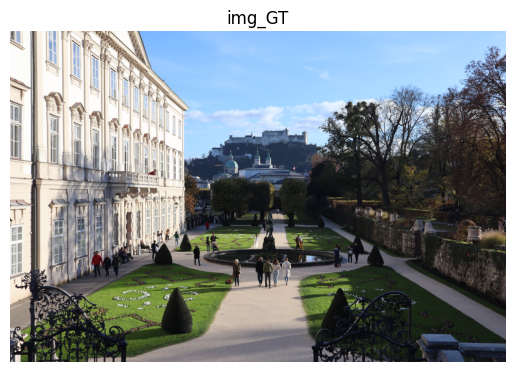

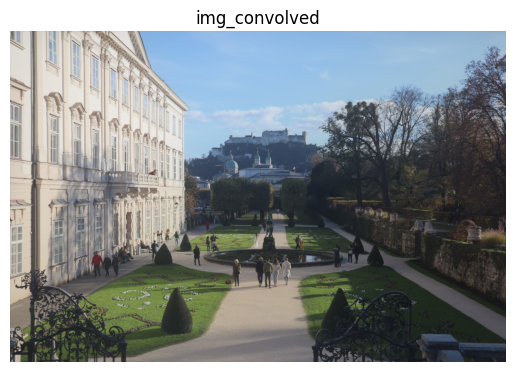

In [6]:
img_GT= torch.tensor(plt.imread('./img_dataset/img_samples/IMG_3353.JPG'), device=args.device).permute(2,0,1).unsqueeze(0)/255.0
img_convolved = torch.zeros_like(img_GT)

for channel_idx, wvl in enumerate([635e-9, 532e-9, 450e-9]):
    double_layer_complex_grid = torch.concat([2.0*torch.sigmoid(layer2_indices)-1, 
                            2.0*torch.sigmoid(layer1_indices)-1,
                            2.0*torch.sigmoid(shape_indices)-1], dim=1) # 세로 축이 layer2임
    complex_field = lut_sampler(keys=[int(wvl*1e+9)], grid=double_layer_complex_grid)[int(wvl*1e+9)]
    light = pado.Light((1,1,param.R, param.R), pitch=param.DOE_pitch, wvl=wvl, field=complex_field, device=args.device)
    psf = compute_psf(wvl, light, args, 'SBL_ASM', offset=(0, 0), normalize=False)

    img_convolved[:,channel_idx,...] = fft_convolve2d_image_reflection(img_GT[:,channel_idx:channel_idx+1,...], (psf)/(psf).sum())

visualize(img_GT, title='img_GT', axis=False)
visualize(img_convolved, title='img_convolved', axis=False)
